In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset

text = """
Бджілка-трудівниця
Цілий день в турботах
Мед смачний зібрати
Ось її робота.
Над квітучим лугом
Чутно «Жу-жу-жу»
Бджілкам-друзям мед зібрати я допоможу!
"""
text = text.lower()

chars = sorted(list(set(text)))
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

vocab_size = len(chars)


encoded_text = [char_to_idx[char] for char in text]

sequence_length = 30
step = 1
input_sequences = []
target_sequences = []

for i in range(0, len(encoded_text) - sequence_length, step):
    input_sequences.append(encoded_text[i:i + sequence_length])
    target_sequences.append(encoded_text[i + sequence_length])

input_sequences = torch.tensor(input_sequences, dtype=torch.long)
target_sequences = torch.tensor(target_sequences, dtype=torch.long)


In [42]:
class TextGenerationRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_rate):
        super(TextGenerationRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

embed_size = 128
hidden_size = 256
num_layers = 2
dropout_rate = 0.2

model = TextGenerationRNN(vocab_size, embed_size, hidden_size, num_layers, dropout_rate)


In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
batch_size = 64

# Датасет
class TextDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

dataset = TextDataset(input_sequences, target_sequences)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [57]:
epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(dataloader))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_losses[-1]:.4f}")
 

Epoch 1/50, Loss: 0.0267
Epoch 2/50, Loss: 0.0232
Epoch 3/50, Loss: 0.0211
Epoch 4/50, Loss: 0.0199
Epoch 5/50, Loss: 0.0174
Epoch 6/50, Loss: 0.0171
Epoch 7/50, Loss: 0.0157
Epoch 8/50, Loss: 0.0149
Epoch 9/50, Loss: 0.0137
Epoch 10/50, Loss: 0.0130
Epoch 11/50, Loss: 0.0131
Epoch 12/50, Loss: 0.0124
Epoch 13/50, Loss: 0.0122
Epoch 14/50, Loss: 0.0117
Epoch 15/50, Loss: 0.0120
Epoch 16/50, Loss: 0.0121
Epoch 17/50, Loss: 0.0115
Epoch 18/50, Loss: 0.0115
Epoch 19/50, Loss: 0.0116
Epoch 20/50, Loss: 0.0116
Epoch 21/50, Loss: 0.0125
Epoch 22/50, Loss: 0.0116
Epoch 23/50, Loss: 0.0122
Epoch 24/50, Loss: 0.0117
Epoch 25/50, Loss: 0.0119
Epoch 26/50, Loss: 0.0123
Epoch 27/50, Loss: 0.0121
Epoch 28/50, Loss: 0.0119
Epoch 29/50, Loss: 0.0118
Epoch 30/50, Loss: 0.0123
Epoch 31/50, Loss: 0.0123
Epoch 32/50, Loss: 0.0124
Epoch 33/50, Loss: 0.0122
Epoch 34/50, Loss: 0.0122
Epoch 35/50, Loss: 0.0122
Epoch 36/50, Loss: 0.0124
Epoch 37/50, Loss: 0.0124
Epoch 38/50, Loss: 0.0131
Epoch 39/50, Loss: 0.

In [63]:
def generate_text(model, start_text, length, temperature=1.0):
    model.eval()
    input_seq = [char_to_idx[char] for char in start_text]
    input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0)
    hidden = None
    generated_text = start_text
    
    for _ in range(length):
        with torch.no_grad():
            output, hidden = model(input_seq, hidden)
            output = output / temperature
            probs = torch.softmax(output, dim=-1).squeeze()
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            generated_text += next_char
            input_seq = torch.tensor([[next_char_idx]], dtype=torch.long)
    
    return generated_text

start_text = "бджілка "
print(generate_text(model, start_text, 200))


бджілка гзу иоатаи д зібрати
ось її робота.
над квітучим луугм
лутно «жу-жу-жу-жу-жу-
у»»»йжклкі-ру-яуз
мед лібрати я допоможу!
бжд «ібрати я допоможу!

ед слач-дир зібрати м допоможу!
нел кібрати я допоможу!


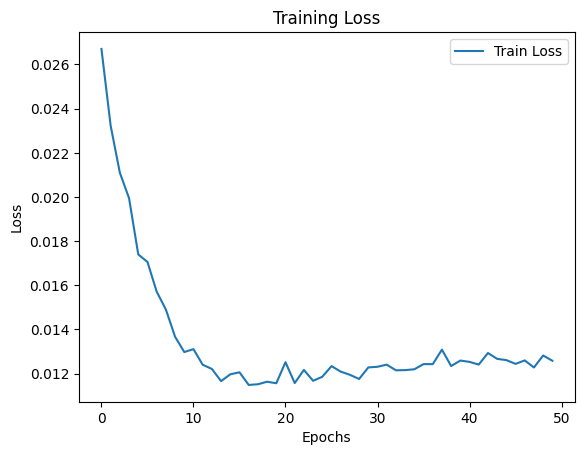

In [64]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()
